# Introduction to Probabilistic programming

#### This notebook is an introduction into Bayesian regression models using NumPyro, it will also employ some more common regression approaches (Ridge, OLS) and compare

This is a practical application of probability theory from my Statistical Learning class at UCL. 

In [23]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Load the data 
data = pd.read_csv("C:\\Users\\sofia\\Downloads\\growth.csv")
data.head()

,Outcome,intercept,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,...,seccf65,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1
0,-0.024336,1,6.591674,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,...,0.04,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727
1,0.100473,1,6.829794,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,...,0.64,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750
2,0.067051,1,8.895082,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,...,18.14,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040
3,0.064089,1,7.565275,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,...,2.63,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195
4,0.027930,1,7.162397,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,...,2.11,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283


In [27]:
# EDA
print("Dataset shape:", data.shape)
print("\nBasic statistics:")
print(data.describe())

# Missing values
print("\nMissing values:")
print(data.isnull().sum())

Dataset shape: (90, 63)

Basic statistics:
         Outcome  intercept   gdpsh465      bmp1l     freeop    freetar  \
count  90.000000       90.0  90.000000  90.000000  90.000000  90.000000   
mean    0.045349        1.0   7.702907   0.168747   0.220102   0.028334   
std     0.051314        0.0   0.896179   0.249116   0.074861   0.021855   
min    -0.100990        1.0   5.762051   0.000000   0.078488   0.000000   
25%     0.021045        1.0   7.131539   0.000000   0.166044   0.011589   
50%     0.046209        1.0   7.725700   0.063800   0.203972   0.025426   
75%     0.074029        1.0   8.441914   0.274550   0.286425   0.039745   
max     0.185526        1.0   9.229849   1.637800   0.416234   0.109921   

             h65       hm65       hf65        p65  ...    seccf65      syr65  \
count  90.000000  90.000000  90.000000  90.000000  ...  90.000000  90.000000   
mean    0.111556   0.137156   0.082233   0.893333  ...   6.171778   0.912422   
std     0.101361   0.116826   0.091549   

In [29]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

# Seperate features and target variable
y = data.iloc[:, 0]
X = data.iloc[:, 1:]

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now fitting the OLS
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
ols_predictions = ols_model.predict(X_test)
ols_coefficients = ols_model.coef_

# Now the Ridge 
ridge_model = Ridge(alpha=1.0) # alpha represents the regularisation strength
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_coefficients = ridge_model.coef_

In [30]:
# import Numpyro for the Bayesian Regression
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
from jax import random

In [33]:
# Defining the Bayesian regression model
def regression_model(X, y=None):
    # Define the priors
    beta = numpyro.sample('beta', dist.Normal(0, 10).expand([X.shape[1]]))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10))

    # Expected value
    mu = jnp.dot(X, beta)

    #Likelihood
    with numpyro.plate('data', X.shape[0]):
        numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [35]:
# Set up the MCMC
kernel = NUTS(regression_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)

# Convert data to JAX arrays
X_jax = jnp.array(X_train)
y_jax = jnp.array(y_train)

# Run the MCMC
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, X_jax, y_jax)

sample: 100%|█████████████████████████| 3000/3000 [02:31<00:00, 19.80it/s, 1023 steps of size 3.11e-04. acc. prob=0.64]


In [37]:
# Getting posterior means from MCMC samples 
mcmc_samples = mcmc.get_samples()
mcmc_coefficients = mcmc_samples['beta'].mean(axis=0)

#Creatw comparison DataFrame
comparison_df = pd.DataFrame({
    'OLS' : ols_coefficients,
    'Ridge' : ridge_coefficients,
    'Bayesian (Posterior Mean)' : mcmc_coefficients
})

# Add feature names
comparison_df.index = X.columns

# Calculate confidence intervals for the Bayesian estimates 
posterior_quantiles = np.percentile(mcmc_samples['beta'], [2.5, 97.5], axis=0)
comparison_df['Bayesian 95% CI'] = [f"({posterior_quantiles[0,i]:.3f}, {posterior_quantiles[1,i]:.3f})"
                                    for i in range(len(mcmc_coefficients))]

# Add model performace metrics
from sklearn.metrics import r2_score, mean_squared_error

performance_metrics = pd.DataFrame({
    'OLS': {
        'R^2' : r2_score(y_test, ols_predictions),
        'MSE' : mean_squared_error(y_test, ols_predictions)
    },
    'Ridge':{
        'R^2' : r2_score(y_test, ridge_predictions),
        'MSE' : mean_squared_error(y_test, ridge_predictions)
    }
})

# Results 
print("Coefficient Comparison:")
print(comparison_df.round(4))
print("\nModel Performance Metrics:")
print(performance_metrics.round(4))
    

Coefficient Comparison:
                    OLS   Ridge  Bayesian (Posterior Mean)   Bayesian 95% CI
intercept  2.080604e+07  0.0000                    -3.4973  (-5.508, -0.544)
gdpsh465   8.200000e-03 -0.0237                    -0.1201   (-0.405, 0.193)
bmp1l     -6.480000e-02 -0.0517                     0.2668   (-0.116, 0.575)
freeop     6.000000e-02  0.0015                    -2.1587  (-2.556, -1.690)
freetar   -1.989000e-01 -0.0064                    -0.2430   (-0.728, 0.191)
...                 ...     ...                        ...               ...
teasec65   4.000000e-04 -0.0001                     0.0022   (-0.023, 0.023)
ex1       -1.044900e+00 -0.0001                     0.8535   (-0.346, 1.584)
im1        1.155100e+00  0.0132                    -0.0690   (-0.205, 0.093)
xr65      -1.000000e-04 -0.0000                    -0.0008   (-0.002, 0.000)
tot1      -3.550000e-01 -0.0081                     1.5370    (0.795, 2.205)

[62 rows x 4 columns]

Model Performance Metrics:
 

# Visualisations

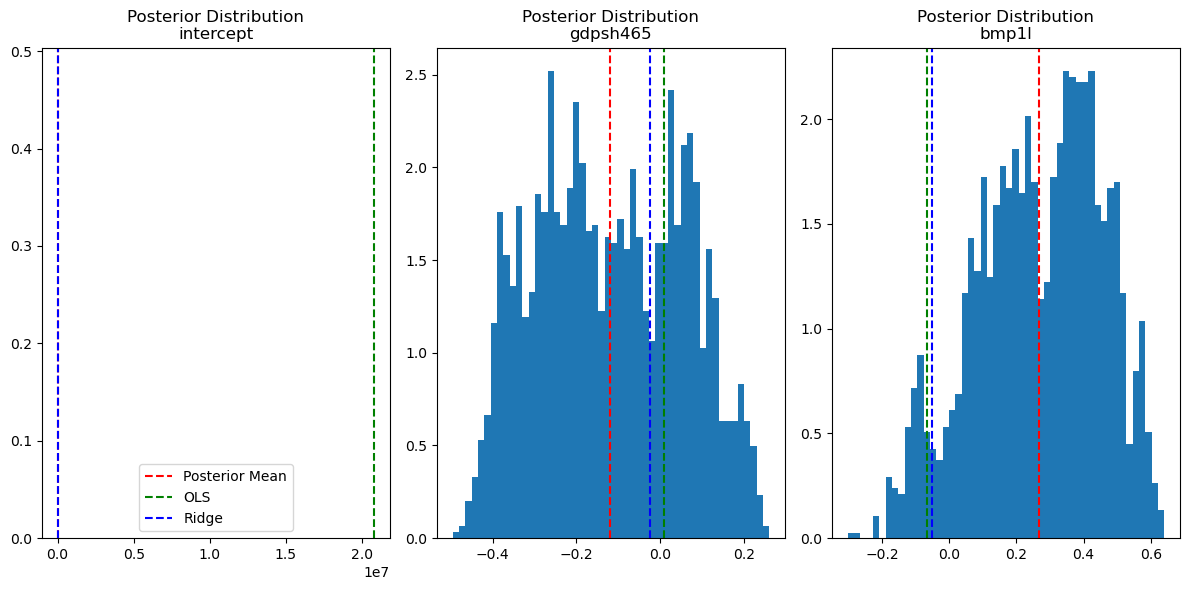

In [44]:

# Plot posterior distributions for a few key coefficients
plt.figure(figsize=(12, 6))
for i, col in enumerate(X.columns[:3]):
    plt.subplot(1, 3, i+1)
    plt.hist(mcmc_samples['beta'][:, i], bins=50, density=True)
    plt.title(f'Posterior Distribution\n{col}')
    plt.axvline(mcmc_coefficients[i], color='r', linestyle='--', label='Posterior Mean')
    plt.axvline(ols_coefficients[i], color='g', linestyle='--', label='OLS')
    plt.axvline(ridge_coefficients[i], color='b', linestyle='--', label='Ridge')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()